In [ ]:
import tensorflow as tf
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.TPUStrategy(tpu)
!pip install imbalanced-learn

In [ ]:
# Step 1: Import Libraries and Load the Dataset
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset from a CSV file
df = pd.read_csv('/content/drive/MyDrive/yuksekTez/airline_dataset/cleaned_text.csv')

Mounted at /content/drive


In [ ]:
with strategy.scope():
  # Step 2: Preprocess the Dataset
  tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
  tokenizer.fit_on_texts(df["text"])
  vocab_size = len(tokenizer.word_index) + 1
  sequences = tokenizer.texts_to_sequences(df["text"])
  maxlen = 100
  padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding="post", truncating="post")
  labels = pd.get_dummies(df["airline_sentiment"]).values
  print(vocab_size)

15770


In [ ]:
# Step 3: Split the Dataset into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.25, random_state=42)

In [ ]:
with strategy.scope():
    model1 = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=maxlen),
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same", activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=3, activation="softmax")
    ])

    model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss="categorical_crossentropy",
                   metrics=["accuracy"])

# Define early stopping callback with reduced patience
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [ ]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 64)           1009280   
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 64)           12352     
                                                                 
 batch_normalization_1 (Batc  (None, 100, 64)          256       
 hNormalization)                                                 
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [ ]:
# Step 5: Compile the Model and Define the Optimizer and Loss Function
model1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 64)           1009280   
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 64)           12352     
                                                                 
 batch_normalization_1 (Batc  (None, 100, 64)          256       
 hNormalization)                                                 
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [ ]:
# Step 5,5: SMOTE
from imblearn.over_sampling import SMOTE

# Initialize SMOTE with hyperparameters
smote = SMOTE(
    sampling_strategy='auto',  # Adjust based on the imbalance ratio
    random_state=42,           # Set a random seed for reproducibility
    k_neighbors=5,             # Number of nearest neighbors to consider
)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_resampled_test, y_resampled_test = smote.fit_resample(X_test, y_test)

In [ ]:
with strategy.scope():
  # Step 6: Train the Model
  history = model1.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
155/155 [==============================] - 11s 39ms/step - loss: 1.0668 - accuracy: 0.5794 - val_loss: 1.1344 - val_accuracy: 0.6539
Epoch 2/100
155/155 [==============================] - 3s 18ms/step - loss: 0.7896 - accuracy: 0.6842 - val_loss: 1.0775 - val_accuracy: 0.5638
Epoch 3/100
155/155 [==============================] - 3s 18ms/step - loss: 0.6483 - accuracy: 0.7565 - val_loss: 0.9026 - val_accuracy: 0.6703
Epoch 4/100
155/155 [==============================] - 3s 19ms/step - loss: 0.5503 - accuracy: 0.8026 - val_loss: 0.6699 - val_accuracy: 0.7568
Epoch 5/100
155/155 [==============================] - 3s 18ms/step - loss: 0.4672 - accuracy: 0.8435 - val_loss: 0.5817 - val_accuracy: 0.7960
Epoch 6/100
155/155 [==============================] - 3s 18ms/step - loss: 0.3956 - accuracy: 0.8687 - val_loss: 0.6058 - val_accuracy: 0.8005
Epoch 7/100
155/155 [==============================] - 3s 18ms/step - loss: 0.3315 - accuracy: 0.8947 - val_loss: 0.6459 - val_accuracy

In [ ]:
# Step 7: Evaluate the Model on the Testing Set
y_pred = model1.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

115/115 [==============================] - 3s 15ms/step
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      2340
           1       0.57      0.57      0.57       738
           2       0.74      0.65      0.69       582

    accuracy                           0.78      3660
   macro avg       0.72      0.70      0.71      3660
weighted avg       0.78      0.78      0.78      3660

[[2048  228   64]
 [ 245  421   72]
 [ 111   91  380]]


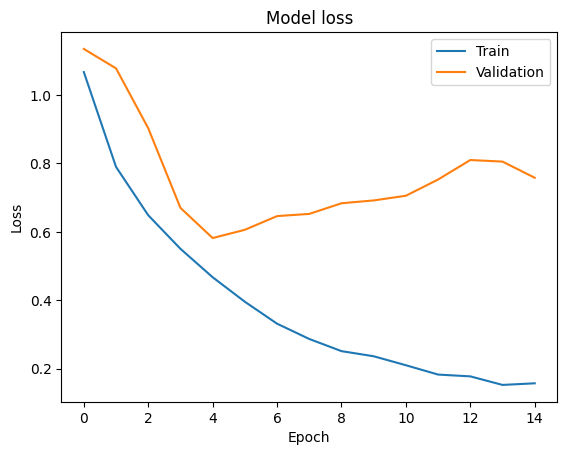

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curve(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

# Assuming 'history' is the variable storing your model's training history
plot_learning_curve(history)


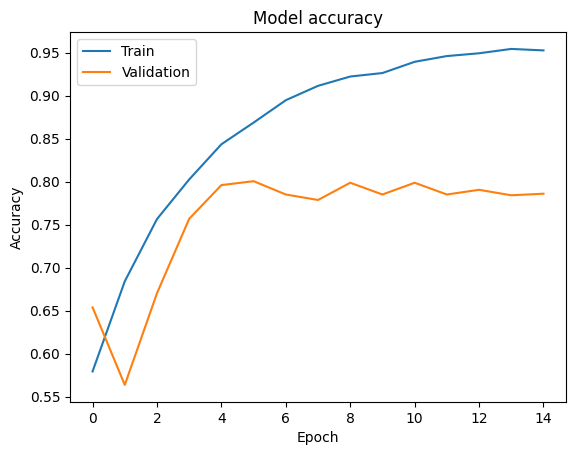

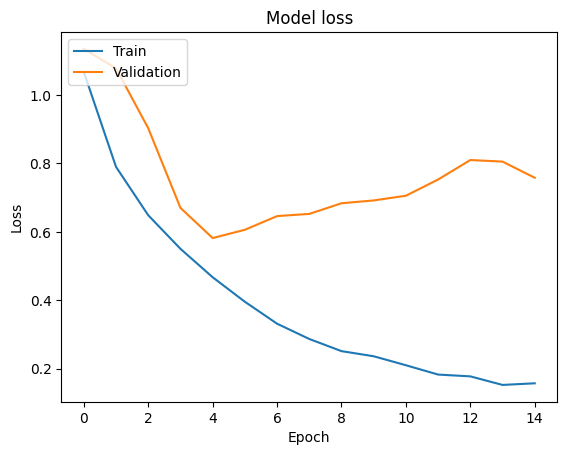

In [ ]:
!pip install matplotlib
import matplotlib.pyplot as plt

def plot_learning_curve(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Assuming 'history' is the variable storing your model's training history
plot_learning_curve(history)


In [ ]:
"""def create_detailed_cnn_model(input_shape, num_classes):
    model2 = Sequential()

    # Convolutional Layer 1
    model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model2.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Layer 2
    model2.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model2.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Layer 3
    model2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model2.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten
    model2.add(Flatten())

    # Fully Connected Layer 1
    model2.add(Dense(512, activation='relu'))
    model2.add(Dropout(0.5))

    # Fully Connected Layer 2
    model2.add(Dense(256, activation='relu'))
    model2.add(Dropout(0.5))

    # Output Layer
    model2.add(Dense(num_classes, activation='softmax'))

    return model2

# Define input shape and number of classes
input_shape = (None, 10000, 3)  # Adjust the input shape based on your data
num_classes = 3  # Change this to the number of classes in your problem

# Create the model
model2 = create_detailed_cnn_model(input_shape, num_classes)

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model2.summary()"""

"def create_detailed_cnn_model(input_shape, num_classes):\n    model2 = Sequential()\n\n    # Convolutional Layer 1\n    model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))\n    model2.add(MaxPooling2D(pool_size=(2, 2)))\n\n    # Convolutional Layer 2\n    model2.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))\n    model2.add(MaxPooling2D(pool_size=(2, 2)))\n\n    # Convolutional Layer 3\n    model2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))\n    model2.add(MaxPooling2D(pool_size=(2, 2)))\n\n    # Flatten\n    model2.add(Flatten())\n\n    # Fully Connected Layer 1\n    model2.add(Dense(512, activation='relu'))\n    model2.add(Dropout(0.5))\n\n    # Fully Connected Layer 2\n    model2.add(Dense(256, activation='relu'))\n    model2.add(Dropout(0.5))\n\n    # Output Layer\n    model2.add(Dense(num_classes, activation='softmax'))\n\n    return model2\n\n# Define input shape and number of classes\ninput_shape = (None, 10000, 3)  # Adjus

In [ ]:
with strategy.scope():
  # Step 6: Train the Model
  history = model1.fit(X_resampled, y_resampled, epochs=100, batch_size=64, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
289/289 [==============================] - 11s 28ms/step - loss: 0.8976 - accuracy: 0.6231 - val_loss: 1.2217 - val_accuracy: 0.1930
Epoch 2/100
289/289 [==============================] - 5s 16ms/step - loss: 0.7349 - accuracy: 0.6892 - val_loss: 1.2558 - val_accuracy: 0.1964
Epoch 3/100
289/289 [==============================] - 5s 16ms/step - loss: 0.6405 - accuracy: 0.7321 - val_loss: 1.1198 - val_accuracy: 0.2656
Epoch 4/100
289/289 [==============================] - 5s 16ms/step - loss: 0.5672 - accuracy: 0.7694 - val_loss: 1.4854 - val_accuracy: 0.1623
Epoch 5/100
289/289 [==============================] - 5s 16ms/step - loss: 0.5043 - accuracy: 0.7942 - val_loss: 1.2972 - val_accuracy: 0.1940
Epoch 6/100
289/289 [==============================] - 4s 15ms/step - loss: 0.4569 - accuracy: 0.8184 - val_loss: 1.1601 - val_accuracy: 0.3977
Epoch 7/100
289/289 [==============================] - 5s 16ms/step - loss: 0.4208 - accuracy: 0.8365 - val_loss: 1.3207 - val_accuracy

In [ ]:
# Step 7: Evaluate the Model on the Testing Set
y_pred = model1.predict(X_resampled_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_resampled_test, axis=1)
print(classification_report(y_resampled_test, y_pred))
print(confusion_matrix(y_resampled_test, y_pred))

220/220 [==============================] - 2s 7ms/step


AxisError: ignored